# _LabLife_ - Predict your Biological Age
## Data Loading and Preparation

Download data from https://github.com/higgi13425/medicaldata/raw/refs/heads/master/data/thiomon.rda

Please install all necessary libraries:
`pip install pyreadr pandas numpy seaborn matplotlib scikit-learn==1.7.0 xgboost==3.1.1`

This section loads the dataset from an R `.rda` file, cleans and standardizes the column names, and fills missing values with zeros.
The data is split into training, validation, and test sets.  
Features are vectorized using `DictVectorizer`.

In [ ]:
import pyreadr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb

df = pd.DataFrame(list(pyreadr.read_r('thiomon.rda').values())[0])
df = df.fillna(0)
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.replace(' ', '', regex=True, inplace=True)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_full_train = df_full_train.days_of_life / 365
y_train = df_train.days_of_life / 365
y_val = df_val.days_of_life / 365
y_test = df_test.days_of_life / 365

for i in [df_full_train, df_train, df_val, df_test]:
    i.drop(columns=['days_of_life', 'active', 'remission'], inplace=True)

dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(df_full_train.to_dict(orient='records'))
X_train = dv.transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

## Exploratory data analysis (EDA)
### Descriptive statistics

In [8]:
eda = df.drop(columns=['days_of_life', 'active', 'remission']).select_dtypes(include=np.number)
eda.describe()

,wbc,hgb,hct,plt,rbc,mcv,mch,mchc,rdw,mpv,...,un,creat,gluc,cal,prot,alb,ast,alt,alk,tbil
count,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,...,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000,5168.00000,5168.000000,5168.000000
mean,7.522988,12.569079,36.933998,311.300310,4.137709,89.936629,30.597736,33.963622,15.645414,8.240015,...,13.621904,0.820433,100.943305,9.250000,6.932914,4.055399,38.313080,41.73239,111.436146,0.889363
std,3.506182,1.898527,5.272351,130.848324,0.676522,8.721974,3.546078,1.685037,2.820998,1.427326,...,8.149171,0.359176,32.382310,0.685262,0.834612,0.671504,203.356335,273.38412,89.269065,2.301008
min,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,41.000000,0.000000,2.900000,1.200000,5.000000,0.00000,13.000000,0.090000
25%,5.200000,11.600000,34.200000,232.000000,3.760000,84.900000,28.700000,33.300000,13.800000,7.300000,...,9.000000,0.600000,84.000000,8.900000,6.500000,3.800000,18.000000,13.00000,64.000000,0.300000
50%,6.800000,12.700000,37.500000,293.000000,4.210000,90.000000,30.800000,34.100000,14.900000,8.000000,...,12.000000,0.800000,93.000000,9.400000,7.100000,4.200000,22.000000,20.00000,85.000000,0.400000
75%,9.000000,13.800000,40.400000,370.000000,4.580000,95.200000,32.700000,34.800000,16.700000,9.200000,...,15.000000,0.900000,107.000000,9.700000,7.500000,4.500000,30.000000,31.00000,124.250000,0.700000
max,33.500000,18.600000,55.200000,1114.000000,7.040000,123.800000,42.300000,38.000000,39.700000,13.500000,...,118.000000,8.400000,486.000000,11.800000,10.000000,5.500000,7765.000000,10666.00000,1938.000000,27.000000


### Histograms

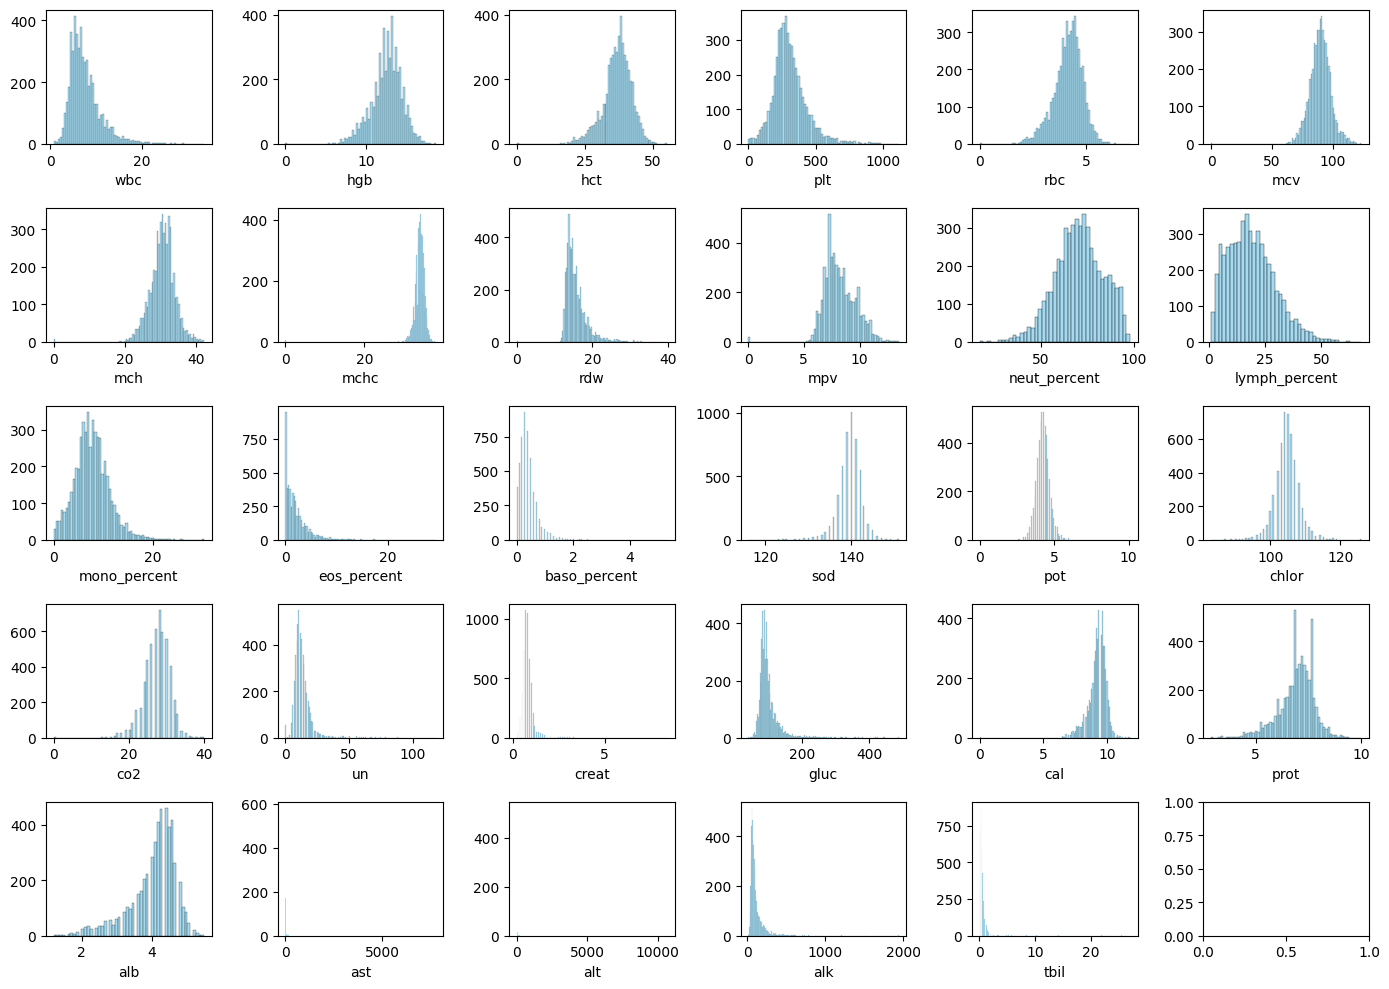

In [9]:
allcols = eda.columns
n_cols = len(allcols)
fig, axes = plt.subplots(5, 6, figsize=(14, 10))
axes = axes.flatten()
for i, col in enumerate(allcols):
    sns.histplot(df[col], ax=axes[i], color="skyblue")
    axes[i].set_ylabel(None) 
plt.tight_layout()
plt.show()

### Correlation Matrix

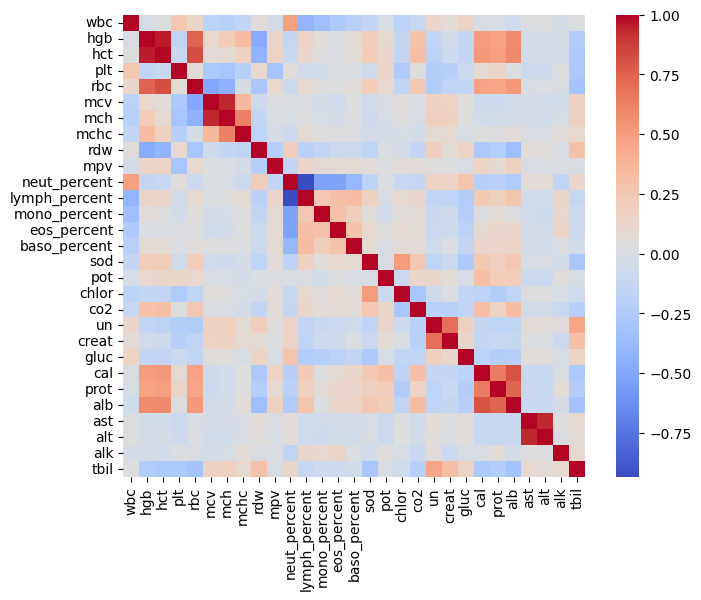

In [10]:
numerical_matrix = df_train.select_dtypes(include='number').corr()
plt.figure(figsize=(8,6))
sns.heatmap(numerical_matrix, annot=False, cmap='coolwarm', square=True)
plt.show()

## Model selection

Calculate RMSE for three models (`LinearRegression`, `RandomForest`, `XGBoost`).
Show results in a boxplot.

LinearRegression..................................................
RandomForest...........................................................................
XGBoost................................................................

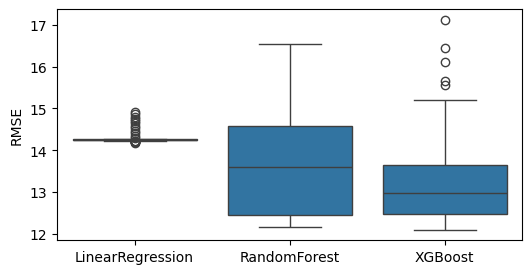

In [11]:
results = []

print('LinearRegression', end='')
for alpha in np.logspace(-4, 4, 50):
    print('.', end='')
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    results.append({
        'model': 'LinearRegression',
        'rmse': np.sqrt(mean_squared_error(y_val, y_pred_val))
    })

print('\nRandomForest', end='')
for n_estimators in [10, 50, 100, 200, 500]:
    for max_depth in [1, 3, 5, 10, 20]:
        for min_samples_split in [2, 5, 10]:
            print('.', end='')
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                n_jobs=-1
            )
            model.fit(X_train, y_train)
            y_pred_val = model.predict(X_val)
            results.append({
                'model': "RandomForest",
                'rmse': np.sqrt(mean_squared_error(y_val, y_pred_val))
            })

print('\nXGBoost', end='')
for n_estimators in [50, 100, 200, 500]:    
    for eta in [0.01, 0.05, 0.1, 0.3]:
        for depth in [1, 3, 5, 10]:
            print('.', end='')
            model = xgb.XGBRegressor(
                n_estimators=n_estimators,
                eta=eta,
                max_depth=depth,
                n_jobs=-1
            )
            model.fit(X_train, y_train)
            y_pred_val = model.predict(X_val)
            results.append({
                'model': "XGBoost",
                'rmse': np.sqrt(mean_squared_error(y_val, y_pred_val))
            })

plt.figure(figsize=(6, 3))
sns.boxplot(x='model', y='rmse', data=pd.DataFrame(results))
plt.ylabel('RMSE')
plt.xlabel('')
plt.show()

## XGBoost Hyperparameter Tuning
Find the optimal parameters for the XGBoost model.

In [13]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    early_stopping_rounds=50,
    eval_metric='rmse'
)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5, 1, 2],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 1, 5, 10],
    'reg_alpha': [0, 0.1, 1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1
)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
print("Best RMSE:", -search.best_score_)
print("Best Params:", search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best RMSE: 11.705724872735027
Best Params: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}


## Final Model
Train the model with the optimal parameters. Train on full training set and check on test data.

In [14]:
model = xgb.XGBRegressor(
    n_estimators=200,
    reg_lambda=0.1,
    reg_alpha=0.1,
    min_child_weight=7,
    max_depth=8,
    learning_rate=0.05,
    gamma=0.5,
    colsample_bytree=0.6
)

model.fit(X_full_train, y_full_train)
y_pred_test = model.predict(X_test)
print("Final RMSE:", np.sqrt(((y_pred_test - y_test)**2).mean()))

Final RMSE: 11.144227013796167
